# `StableReparam` posteriors

This notebook examines the posteriors over the four latent variables introduced by `StableReparam`, conditioned on a single datum and the `Stable` parameters. Our goal is to assess the accuracy of an `AutoNormal` approximation to this posterior, addressing [Pyro issue #3280](https://github.com/pyro-ppl/pyro/issues/3280).

In [1]:
import torch
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.distributions import constraints
from pyro.infer.mcmc import MCMC, NUTS
from pyro.infer.reparam import StableReparam
import matplotlib as mpl
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)
pyro.set_rng_seed(20231006)
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
stability = 1.9
skew = 0.5
scale = 1.0
loc = 0.0
stable = dist.Stable(stability, skew, scale, loc)

In [3]:
@poutine.reparam(config={"x": StableReparam()})
def model(data: torch.Tensor):
    with pyro.plate_stack("data", data.shape):
        pyro.sample("x", stable, obs=data)

Let's sample some representative points.

In [4]:
data = stable.sample([10001])
data, _ = data.sort()
data.shape

torch.Size([10001])

Text(0.5, 1.0, 'Approximate CDF')

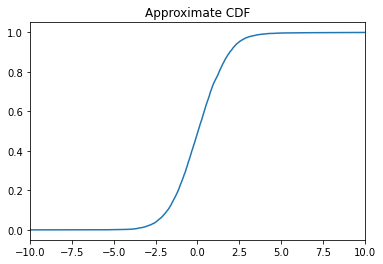

In [5]:
plt.plot(data, torch.linspace(0, 1, len(data)))
plt.xlim(-10, 10)
plt.title("Approximate CDF")

In [6]:
quantiles = torch.tensor([-5.0, -2.5, 0.0, 2.5, 5.0])

In [7]:
# draw samples using Pyro's NUTS
kernel = NUTS(model)
mcmc = MCMC(kernel, num_samples=4000, warmup_steps=400)
mcmc.run(quantiles)
samples = mcmc.get_samples()

Warmup:   0%|                                                                                                    | 0/4400 [00:00, ?it/s]

Sample: 100%|████████████████████████████████████████| 4400/4400 [01:46, 41.12it/s, step size=1.96e-01, acc. prob=0.914]                


In [8]:
{k: v.shape for k, v in sorted(samples.items())}

{'x_t_exponential': torch.Size([4000, 5]),
 'x_t_uniform': torch.Size([4000, 5]),
 'x_z_exponential': torch.Size([4000, 5]),
 'x_z_uniform': torch.Size([4000, 5])}

In [9]:
z = torch.stack([v for k, v in sorted(samples.items())], dim=-1)
z.shape

torch.Size([4000, 5, 4])

In [10]:
mcmc.transforms

{'x_z_uniform': ComposeTransform(
     _InverseTransform(AffineTransform()),
     _InverseTransform(SigmoidTransform())
 ),
 'x_z_exponential': ComposeTransform(
     _InverseTransform(AffineTransform()),
     _InverseTransform(ExpTransform())
 ),
 'x_t_uniform': ComposeTransform(
     _InverseTransform(AffineTransform()),
     _InverseTransform(SigmoidTransform())
 ),
 'x_t_exponential': ComposeTransform(
     _InverseTransform(AffineTransform()),
     _InverseTransform(ExpTransform())
 )}

In [11]:
z_unconstrained = torch.stack(
    [mcmc.transforms[k](v) for k, v in sorted(samples.items())],
    dim=-1
)

In [16]:
def plot_pairs(data_index: int) -> None:
    """lots a 4x4 grid of pairwise scatter plots for each of the four dimensions"""
    samples = z_unconstrained[:, data_index, :].numpy()
    assert samples.shape == (len(samples), 4)
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(4):
        for j in range(4):
            if i == j:
                axs[i, j].hist(samples[:, i], bins=50, lw=0)
                # draw a smoothed histogram
            else:
                axs[i, j].scatter(samples[:, j], -samples[:, i], s=5, alpha=0.3, lw=0)
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
    fig.suptitle(f"reparam z | x = {quantiles[data_index]:0.5g}", fontsize=16)
    plt.subplots_adjust(wspace=0, hspace=0)

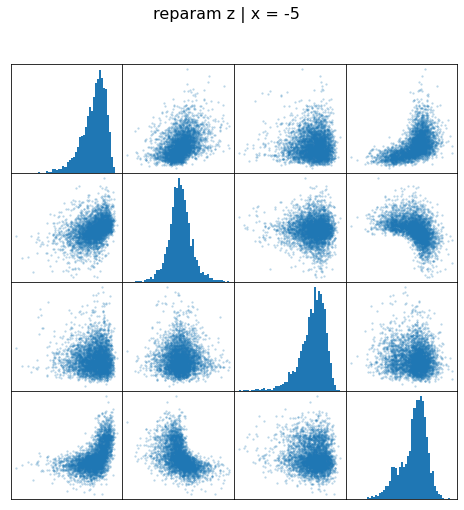

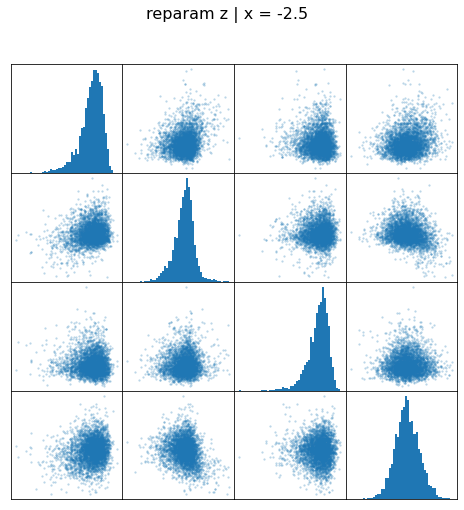

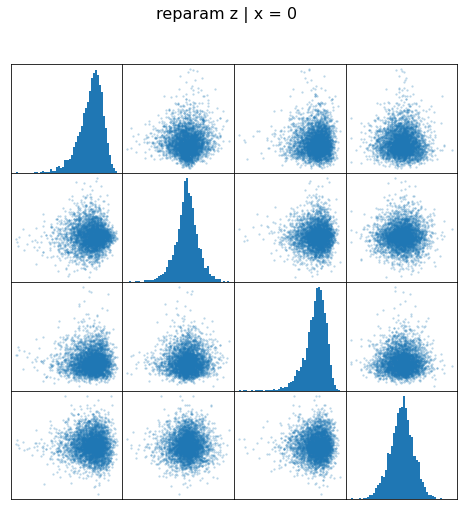

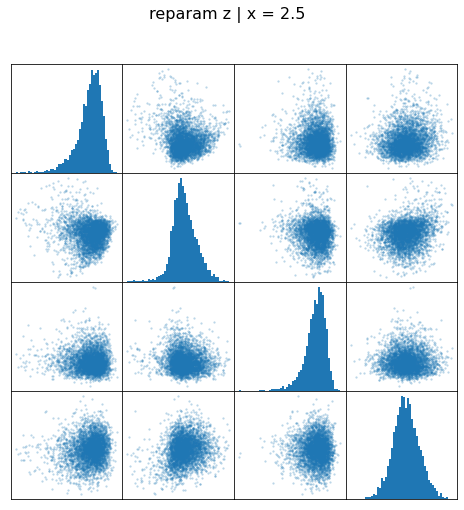

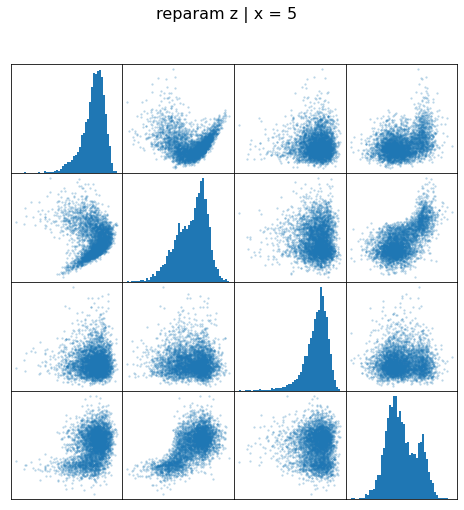

In [17]:
for i in range(len(quantiles)):
    plot_pairs(i)